In [1367]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
import pandas as pd
from scipy.stats import norm, multivariate_normal
import pymc as pm
from scipy.linalg import block_diag
import copy
from filterpy.kalman import KalmanFilter
from tqdm import tqdm

In [1368]:
dates = pd.date_range(start='1/1/2013', end='6/1/2014')
days = np.arange(0, len(dates), 1)
cov_1 = np.sin(2*np.pi/90 * days) 
cov_2 = np.sin(2*np.pi/360 * days)
covs = np.vstack([cov_1, cov_2])

In [1369]:
def make_block(A, B):
    mat = np.block([[A, np.zeros([A.shape[0], B.shape[1]])], [np.zeros([B.shape[0], A.shape[1]]), B]])
    return mat
    

In [1415]:
# local linear trend
Z_1 = np.ones(len(dates)).reshape(1, -1)
T_1 = np.ones(1).reshape(-1, 1)
R_1 = np.eye(1).reshape(-1, 1)

# dynamic regression
Z_2 = covs
T_2 = np.eye(covs.shape[0])
R_2 = np.eye(covs.shape[0])

# combine arrays
Z = np.vstack([Z_1 , Z_2])
T = make_block(T_1, T_2)
R = make_block(R_1, R_2)
Q = np.diag([0.01] * 3)

In [1416]:
alpha.shape, Z.shape

((3, 517), (3, 517))

In [1417]:
alpha = np.zeros((3, len(dates)))
alpha[:, 0] = [10, 5, 0]
for i in range(len(dates)-1):
    alpha[:, i+1] = alpha[:, i]@T  + R@multivariate_normal(cov=Q).rvs()

In [1421]:
y = (Z * alpha).sum(axis=0) + norm(0, .1).rvs(len(dates))
y_observed = copy.copy(y)
y.shape

(517,)

In [1422]:
idx = int(np.where(dates ==  '2014-01-01')[0])
uplift = .2
y_observed[idx:] = y_observed[idx:] * (1 + uplift)

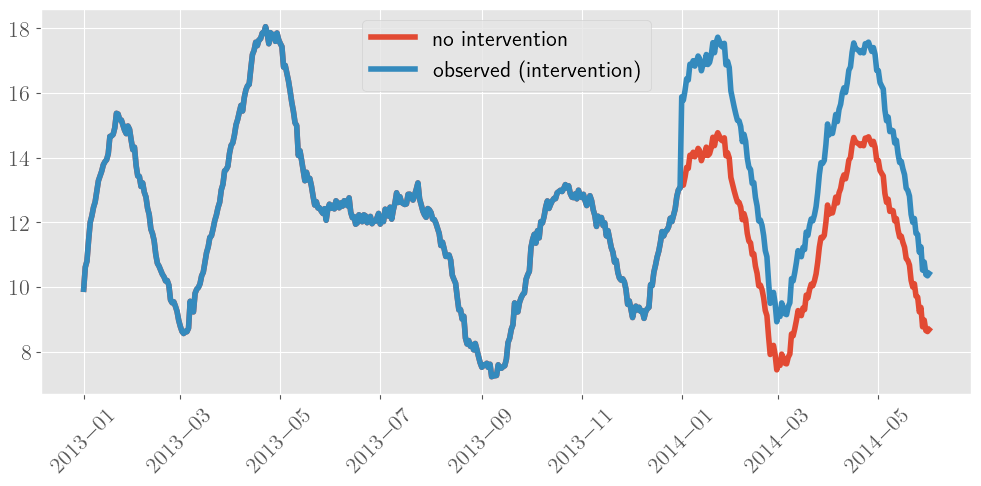

In [1423]:
plt.figure(figsize=(12, 5))
plt.plot(dates, y.flatten(), label='no intervention')
plt.plot(dates, y_observed.flatten(), label='observed (intervention)')
plt.xticks(rotation=45)
plt.legend();

In [1424]:
n_it = len(y) - 1
ndim = 3

def do_filter(sigma_sq, Q=Q, y=y, H=Z, T=T, init_val=10):
    ndim = H.shape[1]
    n_it = y.shape[-1]
    xtt_m1 = np.zeros((n_it + 1, ndim))
    xtt_m1[0, :] = init_val
    xtt = xtt_m1[1:]
    P = np.eye(ndim)  * 10000
    print(H.shape)
    for it in tqdm(range(n_it)):
        Ft = H[it, :]@P@H[it, :].T + sigma_sq
        vt = y[it] - H[it, :]@xtt_m1[it, :]
        Kt = P@H[it, :].T * 1/Ft
        xtt[it, :] = xtt_m1[it, :] +  Kt*vt
        xtt_m1[it+1, :] = copy.copy(xtt[it, :])
        middle = H[it,:].reshape(-1, 1)@H[it, :].reshape(-1, 1).T
        P_tt =  (np.eye(ndim) - 1/Ft * P@middle)@P
       
        #print(P_tt)
        #xtt[it + 1, :] = G@mu_tt
        P = T@P_tt@T.T + Q
   # plt.plot(xtt)
    return xtt

(517, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 22743.99it/s]


(-5.0, 20.0)

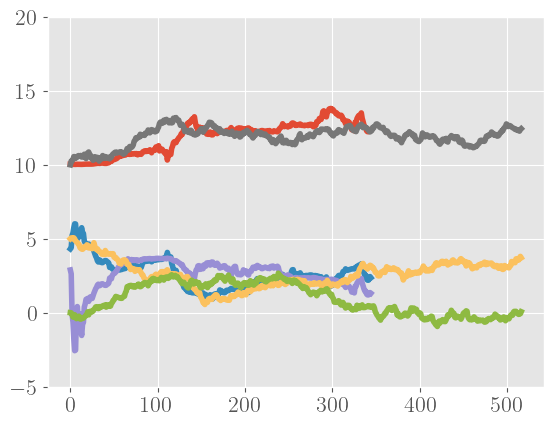

In [1425]:
mu_t = do_filter(sigma_sq=.1**2, y=y[:idx], H=Z.T, T=T, Q=Q, init_val=[0, 0, 0])
plt.plot(mu_t[20:]);
plt.plot(alpha.T)
plt.ylim(-5, 20)

In [1426]:
def predict(last_state, Z, T, R, Q):
    length = Z.shape[1]
    ndim = last_state.shape[0]
    prediction = np.zeros(length)
    states = np.zeros((ndim, length))
    states[:, 0] = copy.copy(last_state)
    for i in range(length - 1):
        states[:, i+1] = states[:, i]@T  + R@multivariate_normal(cov=Q).rvs()
    y = (Z * states).sum(axis=0) + norm(0, .1).rvs(length)
    return y

In [1427]:
n_pred = 500
preds = np.array([predict(mu_t[-1, :], Z[:, idx:], T, R, Q) for _ in range(n_pred)])

In [1428]:
preds.shape

(500, 152)

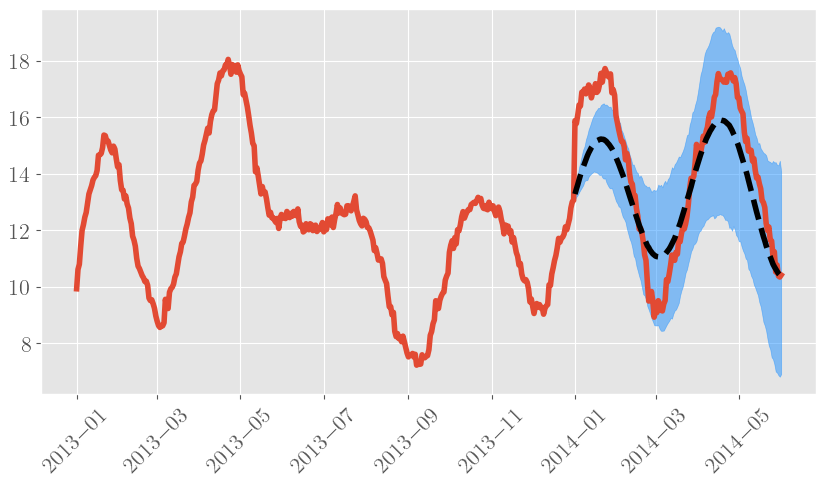

In [1430]:
plt.figure(figsize=(10, 5))
plt.plot(dates, y_observed)
conf = np.quantile(preds, [.05/2, 1-0.05/2], axis=0)
plt.fill_between(dates[idx:], * conf, color='dodgerblue', alpha=.5)
plt.plot(dates[idx:], preds.mean(axis=0), color='black', linestyle='--')
plt.xticks(rotation=45);

In [1301]:
x = np.ones((5, 2))
def density(y, mean, cov):
    density = (y - mean).T @ np.linalg.inv(cov) @ (y - mean)
    return density

In [1299]:
 density(x, mean=np.array([1, 1]), cov=np.eye(2))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 5)

In [1290]:
multivariate_normal(mean=[1, 1], cov=np.eye(2)).pdf(x=x)

array([0.15915494, 0.15915494, 0.15915494, 0.15915494, 0.15915494])

In [1199]:
def KF(y,A,H,R,Q,x10,V10):
    leng = len(y)
    statedim = len(x10)
    #initialization of the variance V_{t|t-1}
    Vttm1 = copy.copy(V10)
    #collect the state vectors x_{t|t-1} and x_{t|t}
    xttm1 = np.zeros((leng + 1, statedim)) 
    xtt = np.zeros((leng + 1, statedim)) 
    xttm1[0,:] = copy.copy(x10)
    ptiny()
    #start KF recursions
    for i in range(leng):
        #Var(y_k|y_{1:k-1})
        Vy = H[i, :]@Vttm1@H[i, :].T + R
        #forecast error (out of sample)
        epsilon = y[i] - H[i,]@xttm1[i,:]
        #update x_{t|t} and x_{t+1|t}
        xtt[i,:] = xttm1[i,:] + 1/(Vy) * Vttm1@H[i,:]*epsilon
        xttm1[i+1,:] = copy.copy(xtt[i,:])
        #update V_{t|t}
        Vtt = Vttm1 - 1/Vy * Vttm1@H[i,:].reshape(-1, 1)@H[i, :].reshape(-1, 1).T@Vttm1
        #update V_{t+1|t}
        Vttm1  = A@Vtt@A.T + Q 
    
    return xtt


In [983]:
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=2)
    like_y = pm.Normal('like_y', mu=mu_t[:, 0][:-1], sigma=sigma, observed=mu_t[:, 0][1:])    
    traces = pm.sample(return_inferencedata=None,  chains=1, draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [986]:
np.std(mu_t[:, 0][:-1] - mu_t[:, 0][1:])

0.10078181927907076

In [1003]:
np.std(alpha[0, :][:-1] - alpha[0, :][1:])

0.09931385979851533

(array([ 12.,  38.,  92., 122.,  96.,  77.,  41.,  16.,   3.,   3.]),
 array([0.0088486 , 0.00921693, 0.00958526, 0.00995359, 0.01032192,
        0.01069025, 0.01105858, 0.01142691, 0.01179524, 0.01216357,
        0.0125319 ]),
 <BarContainer object of 10 artists>)

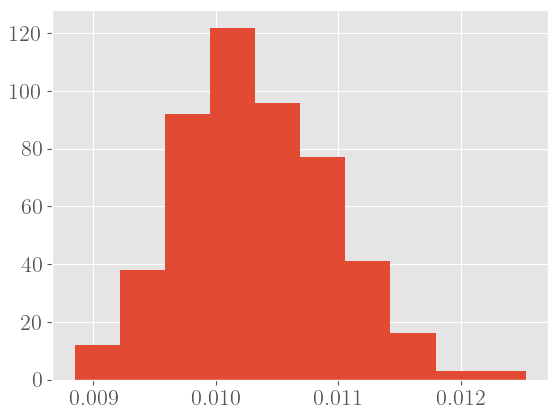

In [1005]:
plt.hist(traces['sigma'] ** 2)

In [1001]:
with pm.Model() as model:
    q = pm.HalfCauchy('sigma', beta=2)
    ypred = (mu_t * Z[:, 1:].T).sum(axis=1)
    like_y = pm.Normal('like_y', mu=ypred, sigma=sigma, observed=y[1:])    
    traces = pm.sample(return_inferencedata=None,  chains=1, draws=500, tune=500)

MissingInputError: Input 0 (sigma_log__) of the graph (indices start from 0), used to compute Elemwise{exp,no_inplace}(sigma_log__), was not provided and not given a value. Use the Aesara flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_7045/1330147960.py", line 2, in <module>
    sigma = pm.HalfCauchy('sigma', beta=2)
  File "/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 292, in __new__
    rv_out = model.register_rv(
  File "/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/pymc/model.py", line 1332, in register_rv
    self.create_value_var(rv_var, transform)
  File "/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/pymc/model.py", line 1488, in create_value_var
    value_var = rv_var.type()


(array([ 14.,  64., 144., 143.,  86.,  36.,  12.,   0.,   0.,   1.]),
 array([0.18707984, 0.19186273, 0.19664562, 0.20142851, 0.2062114 ,
        0.21099429, 0.21577718, 0.22056007, 0.22534296, 0.23012585,
        0.23490874]),
 <BarContainer object of 10 artists>)

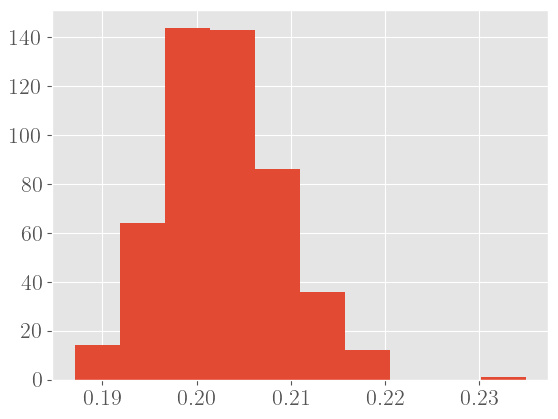

In [979]:
plt.hist(traces['sigma'])

In [676]:
 mu_t = do_filter(sigma_sq=.1**2, y=y, H=Z, G=T, Q=Q, init_val=[10, 0, 0])

ValueError: could not broadcast input array from shape (3,) into shape (517,)

In [677]:
plt.plot((Z * mu_t.T).sum(axis=0))
plt.ylim(-10, 50)
plt.plot(y)

ValueError: operands could not be broadcast together with shapes (3,517) (518,3) 

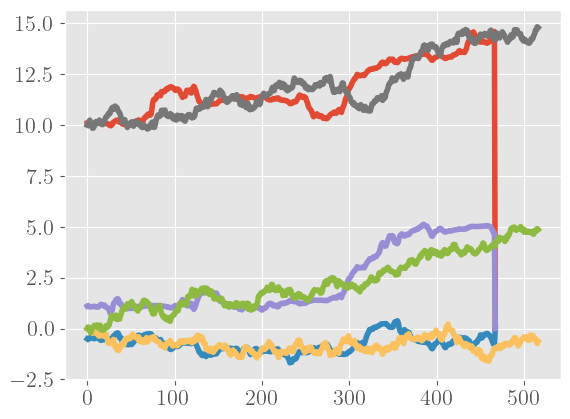

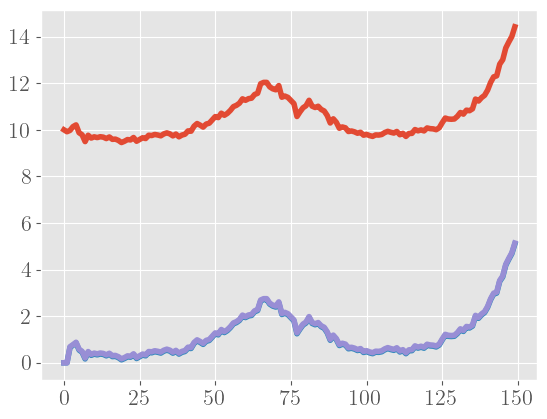

In [597]:
plt.plot(mu_t[:, 0][:150])
plt.plot(mu_t[:, 1][:150])
plt.plot(mu_t[:, 2][:150])

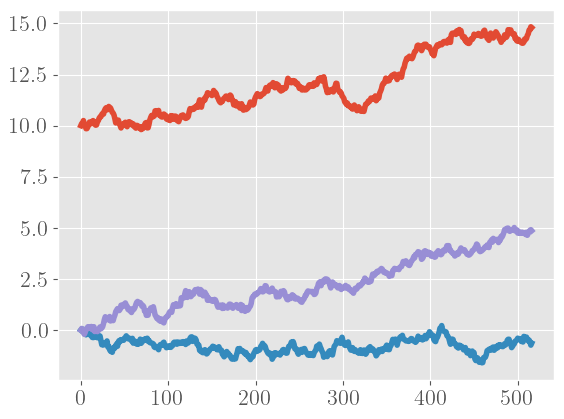

In [546]:
plt.plot(alpha.T)

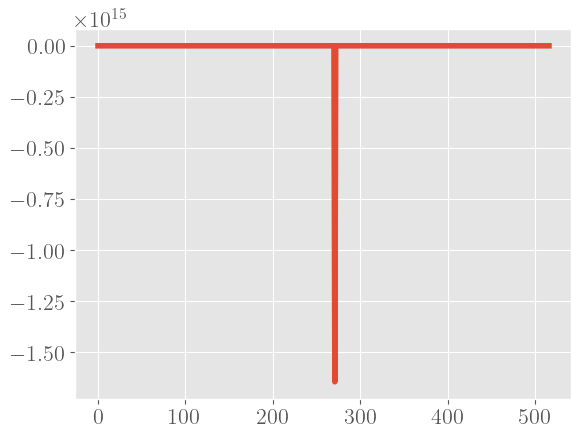

In [471]:
plt.plot(mu_t[:, 1])


In [472]:



#plt.plot(alpha[0, :])

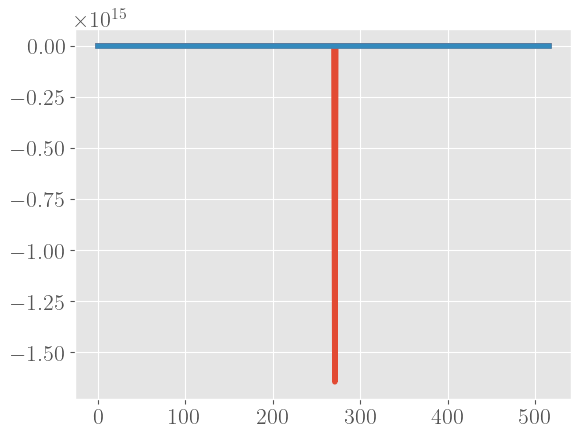

In [466]:
plt.plot(mu_t[:, 0])
plt.plot(alpha[0, :])

##plt.plot(mu_t[:, 1])
#plt.plot(mu_t[:, 2])

In [ ]:
A = np.tri(len(y) - 1)
mat = A @A.T
with pm.Model() as model:
    
    mu_0 = pm.Normal('mu_0', 0, 10)
    beta_1_0 = pm.Normal('beta_1_0', 0, 10)
    beta_2_0 = pm.Normal('beta_2_0', 0, 10)
    q = pm.HalfCauchy('q', beta=1)
    cov = q * mat
    sigma_sq = pm.HalfCauchy('sigma_sq', beta=1)
    mus = pm.MvNormal('mus', mu=mu_0, cov=cov)
    beta_1 = pm.MvNormal('beta1', mu=beta_1_0 , cov=cov)
    beta_2 = pm.MvNormal('beta2', mu=beta_2_0, cov=cov)
    
    yt = mus*Z[0, :][1:] + (beta_1*Z[1, :][1:]) + (beta_2*Z[2, :][1:])
    like = pm.Normal('like', mu=yt, sigma=np.sqrt(sigma_sq), observed=y[1:])
    traces = pm.sample(return_inferencedata=None,  chains=1, draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_0, beta_1_0, beta_2_0, q, sigma_sq, mus, beta1, beta2]


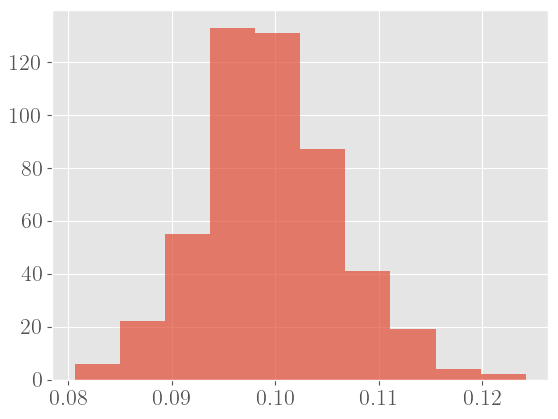

In [20]:
plt.hist(np.sqrt(traces['sigma_sq']), alpha=.7);

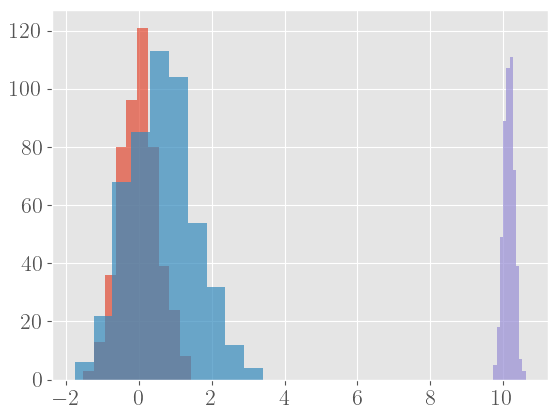

In [22]:
plt.hist(traces['beta_1_0'], alpha=.7);
plt.hist(traces['beta_2_0'], alpha=.7);
plt.hist(traces['mu_0'], alpha=.7);

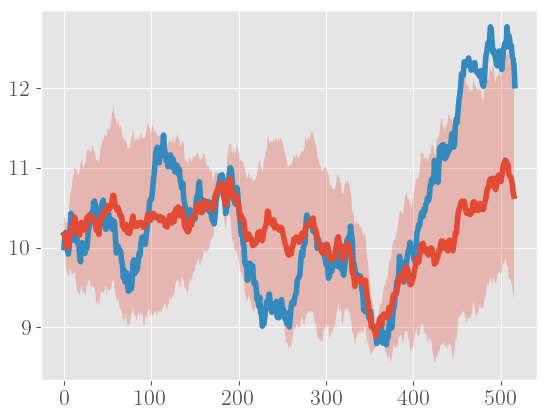

In [28]:
conf = np.quantile(traces['mus'], [.05/2, 1-.05/2], axis=0)
plt.fill_between(np.arange(0, 516, 1), *conf, alpha=.3);
plt.plot(traces['mus'].mean(axis=0), zorder=3);
plt.plot(alpha[0, :])

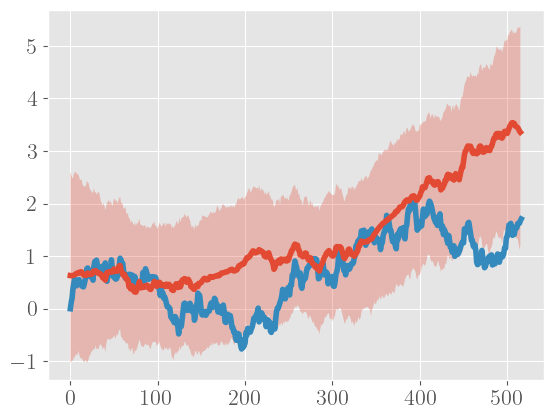

In [26]:
conf = np.quantile(traces['beta2'], [.05/2, 1-.05/2], axis=0)
plt.fill_between(np.arange(0, 516, 1), *conf, alpha=.3);
plt.plot(traces['beta2'].mean(axis=0), zorder=3);
plt.plot(alpha[2, :])

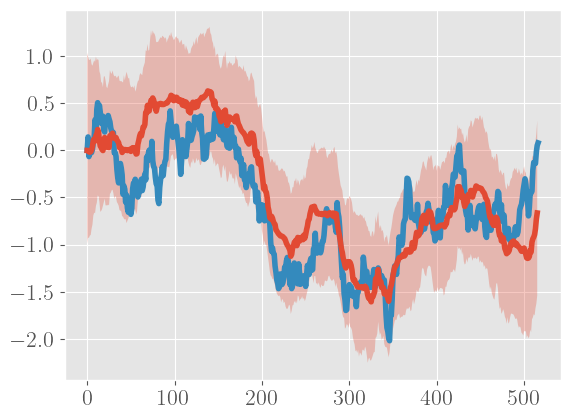

In [27]:
conf = np.quantile(traces['beta1'], [.05/2, 1-.05/2], axis=0)
plt.fill_between(np.arange(0, 516, 1), *conf, alpha=.3);
plt.plot(traces['beta1'].mean(axis=0), zorder=3);


plt.plot(alpha[1, :])

In [ ]:
plt.plot(traces['mus'].mean(axis=0));
plt.plot(alpha[0, :])

In [ ]:
conf = np.quantile(traces['mus'], [.05, 1-.05], axis=0)

In [ ]:
plt.plot(traces['mus'].mean(axis=0));
plt.plot(alpha[0, :])



In [ ]:
plt.plot(traces['mus'].mean(axis=0));
#plt.plot(conf[0])
#plt.plot(conf[1])

plt.plot(alpha[0, :]);

In [ ]:
mu = multivariate_normal(mean=[10] * (len(y) - 1), cov=cov)
plt.plot(mu.rvs(100).T)
plt.plot(alpha[0, :])

In [ ]:
alpha = np.zeros((3, len(dates)))
alpha[:, 0] = [10, 0, 0]
for _ in range(100):
    for i in range(len(dates)-1):
        alpha[:, i+1] = alpha[:, i]@T  + R@multivariate_normal(cov=Q).rvs()
    plt.plot(alpha[0, :])

In [ ]:
dim = 3
V10 = 10000*np.eye(dim)
x10 = np.zeros(dim)


KF(y[1:treatment],A=T,H=Z[1:treatment,, drop=F],R=sigmasq,Q,x10,V10)

def KF(y,A=T,H,R,Q,x10,V10):

In [ ]:
with pm.Model() as model:
    Q_terms = pm.Uniform('Q', 0, 5, shape=3)
    eps = pm.Uniform('eps', 0, 5)
    alpha = np.zeros((3, len(dates)))
    alpha[:, 0] = [10, 0, 0]
    for i in range(len(dates)-1):
        alpha[:, i+1] = alpha[:, i]@T 
    alpha = alpha + np.dot(R, Q_terms)
    
    pred = (Z * alpha).sum(axis=0) 
    like = pm.Normal('like', mu=pred, sigma=eps, observed=y)
    traces = pm.sample(return_inferencedata=None, target_accept=.99, chains=1)

In [ ]:
q = np.array([5, 5, 5])
np.dot(R, q)

In [ ]:
R * q

In [ ]:
for i in range(len(dates)-1):
        alpha[:, i+1] = alpha[:, i]@T  + R@np.sqrt(np.array([1, 1, 1]))

In [ ]:
alpha

In [ ]:
def draw_betas(betas, idx, sig):
    betas[idx+1] = norm(betas[idx], sig).rvs()
    return betas

def draw_mus(mus, idx, sig):
    mus[idx+1] = norm(mus[idx], sig).rvs()
    return mus
    
def make_betas_vector(n, sig=.01):
    betas = np.ones(n)
    for idx in range(n-1):
        betas = draw_betas(betas, idx, sig)
    return betas

def make_mus_vector(n, sig=.1):
    mus = np.zeros(n)
    for idx in range(n-1):
        mus = draw_mus(mus, idx, sig)
    return mus

In [ ]:

beta_1 = make_betas_vector(len(dates))
beta_2 = make_betas_vector(len(dates))
mus = make_mus_vector(len(dates))
eps = norm(0, .1).rvs(len(dates))
uplift = .2
data = beta_1*cov_1 + beta_2*cov_2 + mus + eps
plt.figure(figsize=(10, 5))
plt.plot(dates, data)


plt.xticks(rotation=45)
plt.plot(dates, data)
plt.plot(dates, cov_1)
plt.plot(dates, cov_2)

In [ ]:
with pm.Model() as model:
    sig_1 = np.sqrt(pm.InverseGamma('sig1', 0.5, 0.5))
    sig_2 = np.sqrt(pm.InverseGamma('sig2', 0.5, 0.5))                
    sig_mu = np.sqrt(pm.InverseGamma('sig_mu', 0.5, 0.5))
    betas_1 = make_betas_vector(idx, sig_1.eval())
    betas_2 = make_betas_vector(idx, sig_2.eval())
    mus =  make_mus_vector(idx, sig_mu.eval())
    eps = np.sqrt(pm.InverseGamma('sigma', 0.5, 0.5))
    like = pm.Normal('like', betas_1 * cov_1[:idx] + betas_2 * cov_2[:idx] + mus, eps, observed=data[:idx])
    traces = pm.sample(return_inferencedata=None, target_accept=.99, chains=1)


In [ ]:
betas_1

In [ ]:
traces['like']

In [ ]:
plt.hist(traces['sig1'
               ])

In [ ]:
betas_1_mean = traces['betas1'].mean(axis=0)
betas_2_mean = traces['betas2'].mean(axis=0)
mus_mean = traces['mus'].mean(axis=0)
betas_1_full = np.concatenate([betas_1_mean, np.zeros(len(dates)-idx)])
betas_2_full = np.concatenate([betas_2_mean, np.zeros(len(dates)-idx)])
mus_full = np.concatenate([mus_mean, np.zeros(len(dates)-idx)])

for idx in range(idx, len(n_pred)):
    betas_1_full[idx] = norm(betas_1_full[idx], )

In [ ]:
betas_1_full[idx]

In [ ]:
plt.hist(traces['mus'][:, 0]);
plt.hist(traces['mus'][:, 5]);